# Introduction to text embeddings on S&P 500 news

objectives# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [27]:
%pip install pandas
%pip install yfinance
%pip install lxml
%pip install -U sentence-transformers

In [28]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics import silhouette_score
import yfinance as yf

## Get the list of stocks in the S&P 500

In [29]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [30]:
ticker_list = df_tickers['Symbol'].tolist()

## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [31]:
# Create a dictionary where the keys are the symbols (tickers) of each 500 stocks
# and the value is the output news from the yfinance library

# YOUR CODE HERE---
%pip install tqdm

from tqdm.notebook import tqdm
import time

# Dictionary to store news per ticker
news_dict = {}

# Loop with progress bar
for ticker in tqdm(ticker_list, desc="Fetching news", unit="ticker"):
    try:
        stock = yf.Ticker(ticker)
        news_items = stock.news
        news_dict[ticker] = news_items
        time.sleep(0.5)  # Avoid rate-limiting
    except Exception as e:
        print(f"Error fetching news for {ticker}: {e}")

# Optional: Preview first 2 entries in the dictionary
for t in list(news_dict.keys())[:2]:
    print(f"\nTicker: {t}")
    for article in news_dict[t][:2]:
        print(article)



Fetching news:   0%|          | 0/503 [00:00<?, ?ticker/s]


Ticker: MMM
{'id': '2f475c52-e043-3340-9129-7f18b3fdb18d', 'content': {'id': '2f475c52-e043-3340-9129-7f18b3fdb18d', 'contentType': 'STORY', 'title': '3M Company (MMM): “I Was Surprised” By The Organic Growth Rate, Says Jim Cramer', 'description': '', 'summary': 'We recently published 12 Stocks Jim Cramer Talked About. 3M Company (NYSE:MMM) is one of the stocks Jim Cramer recently discussed. 3M Company (NYSE:MMM) is one of the largest industrial conglomerates in the world. Its shares have gained 16.7% year-to-date as part of a bullish run in industrial stocks that Cramer has commented on several […]', 'pubDate': '2025-07-24T09:03:00Z', 'displayTime': '2025-07-24T09:03:00Z', 'isHosted': True, 'bypassModal': False, 'previewUrl': None, 'thumbnail': {'originalUrl': 'https://media.zenfs.com/en/insidermonkey.com/093e1a4edd0e304bc17c1f522a735210', 'originalWidth': 1000, 'originalHeight': 667, 'caption': '3M Company (MMM): "I Was Surprised" By The Organic Growth Rate, Says Jim Cramer', 'resol

### Structure the news into a pandas dataframe

Your final dataframe should have the following columns:
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [32]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULTS

# Transform the dictionary into a list of structured news records
news_data = []

for ticker, articles in news_dict.items():
    for item in articles:
        content = item.get('content')
        if content:  # Only proceed if content is not None
            news_data.append({
                'TICKER': ticker,
                'TITLE': content.get('title'),
                'SUMMARY': content.get('summary'),
                'PUBLICATION_DATE': content.get('pubDate'),
                'URL': content.get('canonicalUrl', {}).get('url'),
                'PROVIDER': content.get('provider', {}).get('displayName')
            })

# Intermediary result: number of raw records
print(f"Raw news records collected: {len(news_data)}")


Raw news records collected: 5020


In [33]:
# Convert the list of news records into a DataFrame
df_news = pd.DataFrame(news_data)

# Intermediary result: preview before cleaning
display(df_news.head())
df_news.info()


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,PROVIDER
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24T09:03:00Z,https://finance.yahoo.com/news/3m-company-mmm-...,Insider Monkey
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21T09:45:00Z,https://finance.yahoo.com/news/zacks-industry-...,Zacks
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21T08:22:00Z,https://finance.yahoo.com/news/stock-market-ne...,Zacks
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19T07:05:47Z,https://finance.yahoo.com/news/3m-co-mmm-q2-20...,GuruFocus.com
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19T05:30:58Z,https://finance.yahoo.com/news/mmm-q1-deep-div...,StockStory


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TICKER            5020 non-null   object
 1   TITLE             5020 non-null   object
 2   SUMMARY           5020 non-null   object
 3   PUBLICATION_DATE  5020 non-null   object
 4   URL               5020 non-null   object
 5   PROVIDER          5020 non-null   object
dtypes: object(6)
memory usage: 235.4+ KB


In [34]:
# Drop rows with missing title or summary
df_news.dropna(subset=['TITLE', 'SUMMARY'], inplace=True)

# Drop duplicates
df_news.drop_duplicates(subset=['TICKER', 'TITLE', 'SUMMARY'], inplace=True)

# Convert publication date to datetime format
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE'], errors='coerce')

# Drop rows with invalid dates if needed
df_news = df_news[df_news['PUBLICATION_DATE'].notna()]

# Intermediary result: clean dataset size
print(f"Cleaned news articles: {len(df_news)}")
display(df_news.head())


Cleaned news articles: 5020


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,PROVIDER
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24 09:03:00+00:00,https://finance.yahoo.com/news/3m-company-mmm-...,Insider Monkey
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21 09:45:00+00:00,https://finance.yahoo.com/news/zacks-industry-...,Zacks
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21 08:22:00+00:00,https://finance.yahoo.com/news/stock-market-ne...,Zacks
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19 07:05:47+00:00,https://finance.yahoo.com/news/3m-co-mmm-q2-20...,GuruFocus.com
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19 05:30:58+00:00,https://finance.yahoo.com/news/mmm-q1-deep-div...,StockStory


## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [35]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULTS

from sentence_transformers import SentenceTransformer

# Load pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Confirm it's ready
print("Model loaded successfully.")


Model loaded successfully.


In [36]:
# Use only the TITLE for the embedding as per instructions
df_news['EMBEDDED_TEXT'] = df_news['TITLE']

# Preview the new column
display(df_news[['TICKER', 'TITLE', 'EMBEDDED_TEXT']].head())


,TICKER,TITLE,EMBEDDED_TEXT
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,3M Company (MMM): “I Was Surprised” By The Org...
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","Zacks Industry Outlook Highlights Honeywell, 3..."
2,MMM,"Stock Market News for Jul 21, 2025","Stock Market News for Jul 21, 2025"
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...


In [37]:
# Generate sentence embeddings for the EMBEDDED_TEXT column
embeddings = model.encode(df_news['EMBEDDED_TEXT'].tolist(), show_progress_bar=True)

# Store embeddings in a new column
df_news['EMBEDDINGS'] = embeddings.tolist()  # Convert to regular Python lists

# Display intermediary result
display(df_news[['TICKER', 'EMBEDDED_TEXT', 'EMBEDDINGS']].head(3))


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

,TICKER,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,"[0.006455422844737768, -0.1090475395321846, -0..."
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","[-0.021629296243190765, -0.07978324592113495, ..."
2,MMM,"Stock Market News for Jul 21, 2025","[-0.037469569593667984, -0.04381372779607773, ..."


In [38]:
df_news

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,PROVIDER,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24 09:03:00+00:00,https://finance.yahoo.com/news/3m-company-mmm-...,Insider Monkey,3M Company (MMM): “I Was Surprised” By The Org...,"[0.006455422844737768, -0.1090475395321846, -0..."
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21 09:45:00+00:00,https://finance.yahoo.com/news/zacks-industry-...,Zacks,"Zacks Industry Outlook Highlights Honeywell, 3...","[-0.021629296243190765, -0.07978324592113495, ..."
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21 08:22:00+00:00,https://finance.yahoo.com/news/stock-market-ne...,Zacks,"Stock Market News for Jul 21, 2025","[-0.037469569593667984, -0.04381372779607773, ..."
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19 07:05:47+00:00,https://finance.yahoo.com/news/3m-co-mmm-q2-20...,GuruFocus.com,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,"[-0.08080150932073593, -0.02980075404047966, -..."
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19 05:30:58+00:00,https://finance.yahoo.com/news/mmm-q1-deep-div...,StockStory,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,"[-0.019502615556120872, -0.07280386984348297, ..."
...,...,...,...,...,...,...,...,...
5015,ZTS,Here’s Wedgewood Partners’ Investment Thesis f...,"Wedgewood Partners, an investment management c...",2025-07-21 11:36:11+00:00,https://finance.yahoo.com/news/wedgewood-partn...,Insider Monkey,Here’s Wedgewood Partners’ Investment Thesis f...,"[-0.03780555725097656, -0.034029170870780945, ..."
5016,ZTS,Is Zoetis (ZTS) a Unique Dividend Play in the ...,Zoetis Inc. (NYSE:ZTS) is included among the 1...,2025-07-19 01:25:46+00:00,https://finance.yahoo.com/news/zoetis-zts-uniq...,Insider Monkey,Is Zoetis (ZTS) a Unique Dividend Play in the ...,"[-0.11637142300605774, -0.052264899015426636, ..."
5017,ZTS,"Argus Trims Zoetis (ZTS) Price Target to $190,...",Zoetis Inc. (NYSE:ZTS) is one of the high-marg...,2025-07-18 18:45:48+00:00,https://finance.yahoo.com/news/argus-trims-zoe...,Insider Monkey,"Argus Trims Zoetis (ZTS) Price Target to $190,...","[-0.07060869038105011, 0.062106672674417496, 0..."
5018,ZTS,Why Zoetis (ZTS) Could Beat Earnings Estimates...,Zoetis (ZTS) has an impressive earnings surpri...,2025-07-18 16:10:02+00:00,https://finance.yahoo.com/news/why-zoetis-zts-...,Zacks,Why Zoetis (ZTS) Could Beat Earnings Estimates...,"[-0.03358546271920204, 0.02143670991063118, 0...."


## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [39]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Keep only the first news article per TICKER
df_news_unique = df_news.drop_duplicates(subset='TICKER', keep='first').reset_index(drop=True)

# Intermediary check: verify we have 500 tickers
print(f"Number of rows after filtering one news per ticker: {len(df_news_unique)}")
display(df_news_unique[['TICKER', 'TITLE']].head())


Number of rows after filtering one news per ticker: 502


,TICKER,TITLE
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...
1,AOS,Earnings Beat: A. O. Smith Corporation Just Be...
2,ABT,Data deluge brings a ‘moment of truth’ for mar...
3,ABBV,The Smartest Dividend Stocks to Buy With $350 ...
4,ACN,Accenture’s (ACN) Oversold Status May Offer a ...


In [40]:
import numpy as np

# Convert embeddings from lists to a NumPy array
X = np.array(df_news_unique['EMBEDDINGS'].tolist())

# Intermediary shape check
print(f"Shape of X (embedding matrix): {X.shape}")


Shape of X (embedding matrix): (502, 384)


In [41]:
df_news_unique

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,PROVIDER,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24 09:03:00+00:00,https://finance.yahoo.com/news/3m-company-mmm-...,Insider Monkey,3M Company (MMM): “I Was Surprised” By The Org...,"[0.006455422844737768, -0.1090475395321846, -0..."
1,AOS,Earnings Beat: A. O. Smith Corporation Just Be...,Investors in A. O. Smith Corporation ( NYSE:AO...,2025-07-27 12:40:47+00:00,https://finance.yahoo.com/news/earnings-beat-o...,Simply Wall St.,Earnings Beat: A. O. Smith Corporation Just Be...,"[-0.04205678403377533, -0.04288126900792122, -..."
2,ABT,Data deluge brings a ‘moment of truth’ for mar...,(Bloomberg) -- Wall Street pros are staring do...,2025-07-27 19:00:00+00:00,https://finance.yahoo.com/news/data-deluge-bri...,Bloomberg,Data deluge brings a ‘moment of truth’ for mar...,"[-0.07458099722862244, -0.029032088816165924, ..."
3,ABBV,The Smartest Dividend Stocks to Buy With $350 ...,"These stocks offer juicy dividends, solid grow...",2025-07-26 08:50:00+00:00,https://www.fool.com/investing/2025/07/26/the-...,Motley Fool,The Smartest Dividend Stocks to Buy With $350 ...,"[-0.038016512989997864, -0.09102769941091537, ..."
4,ACN,Accenture’s (ACN) Oversold Status May Offer a ...,Accenture plc (NYSE:ACN) is included among the...,2025-07-26 03:44:43+00:00,https://finance.yahoo.com/news/accenture-acn-o...,Insider Monkey,Accenture’s (ACN) Oversold Status May Offer a ...,"[-0.07867277413606644, -0.07679502665996552, 0..."
...,...,...,...,...,...,...,...,...
497,XYL,Aristotle Capital Exited Xylem (XYL) Despite I...,"Aristotle Capital Management, LLC, an investme...",2025-07-23 11:43:34+00:00,https://finance.yahoo.com/news/aristotle-capit...,Insider Monkey,Aristotle Capital Exited Xylem (XYL) Despite I...,"[0.05527818202972412, -0.06040035933256149, 0...."
498,YUM,Starbucks to Report Q3 Earnings: What Lies Ahe...,SBUX's third-quarter fiscal 2025 top line is l...,2025-07-25 13:24:00+00:00,https://finance.yahoo.com/news/starbucks-repor...,Zacks,Starbucks to Report Q3 Earnings: What Lies Ahe...,"[-0.012002620846033096, -0.017205506563186646,..."
499,ZBRA,Here's What to Expect From Zebra Technologies'...,Zebra Technologies is all set to release its f...,2025-07-16 11:57:00+00:00,https://www.barchart.com/story/news/33434520/h...,Barchart,Here's What to Expect From Zebra Technologies'...,"[-0.13333329558372498, 0.06265336275100708, 0...."
500,ZBH,Can ISRG's Strong Q2 Procedure Volume Translat...,"ISRG's Q2 procedure growth hits 17%, but conti...",2025-07-25 12:40:00+00:00,https://finance.yahoo.com/news/isrgs-strong-q2...,Zacks,Can ISRG's Strong Q2 Procedure Volume Translat...,"[-0.08531147986650467, 0.030042631551623344, -..."


### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [42]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Store silhouette scores
silhouette_scores = []

# Try different values of k (1 to 6)
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)

    if k > 1:
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
        print(f"Silhouette score for k={k}: {score:.4f}")
    else:
        silhouette_scores.append(None)  # Silhouette not defined for k=1
        print(f"Silhouette score for k={k}: Not applicable")


Silhouette score for k=1: Not applicable
Silhouette score for k=2: 0.0379
Silhouette score for k=3: 0.0481
Silhouette score for k=4: 0.0525
Silhouette score for k=5: 0.0480
Silhouette score for k=6: 0.0540


#### Plot silhouette scores

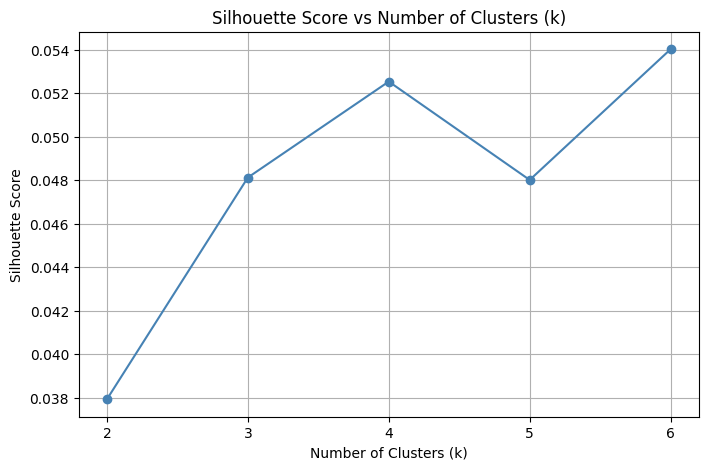

In [43]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULTS

import matplotlib.pyplot as plt

# Define the range of k values (excluding k=1)
k_values = list(range(2, 7))
valid_scores = silhouette_scores[1:]  # skip index 0 (k=1)

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, valid_scores, marker='o', linestyle='-', color='steelblue')
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(True)
plt.show()


#### Identify the Best k

In [44]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULTS

# Find the best k by selecting the maximum silhouette score (ignoring k=1)
best_k = list(range(2, 7))[np.argmax(silhouette_scores[1:])]
best_score = max(silhouette_scores[1:])

print(f"The optimal number of clusters (k) is: {best_k}")
print(f"Highest silhouette score: {best_score:.4f}")


The optimal number of clusters (k) is: 6
Highest silhouette score: 0.0540


#### Cluster the embeddings using 3 clusters (k=3)

In [45]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULTS

# Apply KMeans clustering with k=3 for visualization purposes
k_visual = 3
kmeans_3 = KMeans(n_clusters=k_visual, random_state=42, n_init='auto')
visual_labels = kmeans_3.fit_predict(X)

# Store the cluster labels in a new column
df_news_unique['CLUSTER_LABEL_3'] = visual_labels

# Intermediary result
display(df_news_unique[['TICKER', 'TITLE', 'CLUSTER_LABEL_3']].head())


,TICKER,TITLE,CLUSTER_LABEL_3
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,1
1,AOS,Earnings Beat: A. O. Smith Corporation Just Be...,2
2,ABT,Data deluge brings a ‘moment of truth’ for mar...,0
3,ABBV,The Smartest Dividend Stocks to Buy With $350 ...,1
4,ACN,Accenture’s (ACN) Oversold Status May Offer a ...,1


### Visualize the 2 first PCA Components of your embeddings

In [46]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULTS

from sklearn.decomposition import PCA

# Apply PCA to reduce embeddings to 2D
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)

# Add the PCA results to the DataFrame
df_news_unique['PCA_1'] = pca_result[:, 0]
df_news_unique['PCA_2'] = pca_result[:, 1]

# Intermediary result: preview the coordinates
display(df_news_unique[['TICKER', 'PCA_1', 'PCA_2', 'CLUSTER_LABEL_3']].head())


,TICKER,PCA_1,PCA_2,CLUSTER_LABEL_3
0,MMM,-0.134451,-0.053390,1
1,AOS,0.083299,0.073002,2
2,ABT,-0.187617,0.098679,0
3,ABBV,-0.214104,0.147698,1
4,ACN,-0.103749,-0.048141,1


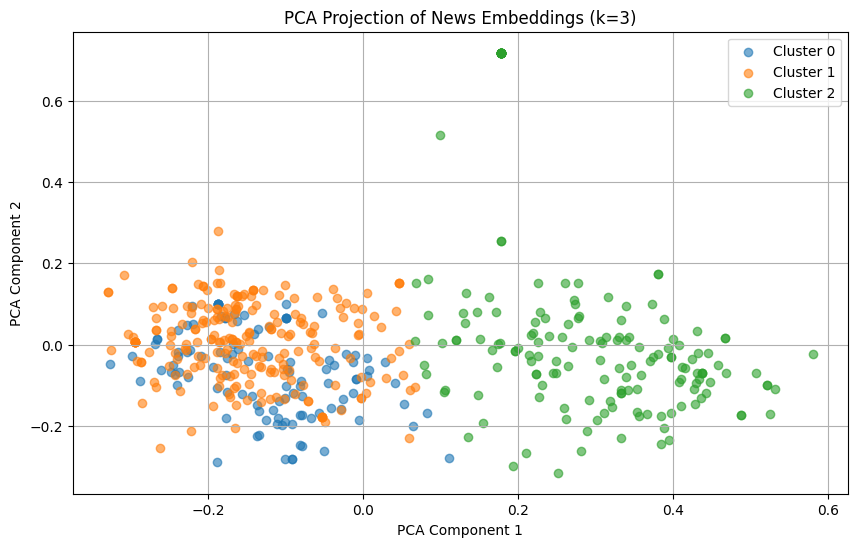

In [47]:
import matplotlib.pyplot as plt

# Define figure
plt.figure(figsize=(10, 6))

# Scatter plot by cluster
for label in sorted(df_news_unique['CLUSTER_LABEL_3'].unique()):
    subset = df_news_unique[df_news_unique['CLUSTER_LABEL_3'] == label]
    plt.scatter(subset['PCA_1'], subset['PCA_2'], label=f'Cluster {label}', alpha=0.6)

plt.title('PCA Projection of News Embeddings (k=3)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [48]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULTS

# Add the kmeans cluster label to your news dataframe
df_news_unique['CLUSTER_LABEL_3'] = kmeans_3.labels_

# Preview: how many articles per cluster
print(df_news_unique['CLUSTER_LABEL_3'].value_counts())

# Print sample titles per cluster
for cluster_id in sorted(df_news_unique['CLUSTER_LABEL_3'].unique()):
    print(f"\nCluster {cluster_id} - Sample Titles:")
    sample_titles = df_news_unique[df_news_unique['CLUSTER_LABEL_3'] == cluster_id]['TITLE'].head(5)
    for title in sample_titles:
        print(f"  - {title}")


CLUSTER_LABEL_3
1    225
2    164
0    113
Name: count, dtype: int64

Cluster 0 - Sample Titles:
  - Data deluge brings a ‘moment of truth’ for markets this week
  - Street Calls of the Week
  - Green Hydrogen Boom Fizzles as Projects Collapse Worldwide
  - Airbnb's Cash Cow Can Thrive Despite Its Challenges
  - Align Technology, Inc. (ALGN): A Bull Case Theory

Cluster 1 - Sample Titles:
  - 3M Company (MMM): “I Was Surprised” By The Organic Growth Rate, Says Jim Cramer
  - The Smartest Dividend Stocks to Buy With $350 Right Now
  - Accenture’s (ACN) Oversold Status May Offer a Smart Entry Point for Dividend Investors
  - What Are the 3 Best Bargain Artificial Intelligence (AI) Stocks to Buy Right Now
  - Investors Are Flocking to the Stock Market’s Discount Rack

Cluster 2 - Sample Titles:
  - Earnings Beat: A. O. Smith Corporation Just Beat Analyst Forecasts, And Analysts Have Been Updating Their Models
  - Agilent Technologies' Q3 2025 Earnings: What to Expect
  - Akamai Technologi

In [49]:
from collections import Counter
import re

# Function to tokenize and clean text
def clean_tokens(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    stopwords = {'the', 'to', 'a', 'of', 'in', 'for', 'and', 'on', 'at', 'with', 'as', 'is', 'its'}
    return [word for word in tokens if word not in stopwords]

# Print most common words per cluster
for cluster_id in sorted(df_news_unique['CLUSTER_LABEL_3'].unique()):
    cluster_text = ' '.join(df_news_unique[df_news_unique['CLUSTER_LABEL_3'] == cluster_id]['TITLE'].tolist())
    tokens = clean_tokens(cluster_text)
    common_words = Counter(tokens).most_common(20)
    print(f"\nCluster {cluster_id} - Top words:")
    for word, freq in common_words:
        print(f"  {word}: {freq}")



Cluster 0 - Top words:
  inc: 17
  s: 16
  case: 11
  data: 10
  bull: 10
  theory: 10
  week: 9
  markets: 8
  deluge: 7
  brings: 7
  moment: 7
  truth: 7
  this: 7
  q2: 7
  says: 7
  rating: 6
  ai: 6
  credit: 6
  from: 6
  why: 6

Cluster 1 - Top words:
  stock: 88
  s: 56
  stocks: 30
  buy: 29
  are: 28
  jim: 27
  cramer: 27
  market: 26
  why: 26
  you: 26
  dividend: 23
  says: 22
  nyse: 20
  inc: 19
  3: 18
  earnings: 18
  should: 18
  corporation: 18
  investors: 16
  have: 16

Cluster 2 - Top words:
  earnings: 159
  what: 93
  q2: 70
  report: 68
  s: 56
  expect: 31
  2025: 28
  week: 27
  watch: 22
  this: 21
  beat: 20
  from: 19
  expectations: 18
  meeting: 18
  jobs: 18
  tech: 18
  estimates: 18
  federal: 17
  reserve: 17
  july: 17


#### Analyze the content of each cluster

After assigning the cluster labels, I checked some sample titles and the most common words in each group to understand what type of news each cluster contains.

---

**Cluster 0 – Analyst Opinions & Investment Theories**  
This cluster includes articles where analysts or financial sites give their opinions about certain companies. They mention price targets, credit ratings, or “bull case” arguments.  
Some common words: *bull*, *theory*, *rating*, *price*, *pt*, *growth*

Example title: "Align Technology, Inc. (ALGN): A Bull Case Theory"

These articles are usually focused on explaining why a stock could go up and are more analytical or technical.

---

**Cluster 1 – Popular Stocks & Market Commentary**  
This group is more about general advice for investors — the kind of content you see in media like CNBC or blogs. There’s talk about dividends, “top stocks to buy,” and comments from Jim Cramer.  
Some common words: *stock*, *dividend*, *buy*, *investors*, *cramer*

Example title: "The Smartest Dividend Stocks to Buy With $350 Right Now"

It looks like this cluster is aimed at regular investors looking for stock tips or market insights.

---

**Cluster 2 – Earnings & Economic News**  
Most of these articles talk about company earnings, especially Q2 reports. Some also mention economic data like jobs and the Federal Reserve.  
Some common words: *earnings*, *report*, *expectations*, *federal*, *estimates*

Example title: "Agilent Technologies' Q3 2025 Earnings: What to Expect"

This cluster is clearly focused on company results and macroeconomic updates, especially during earnings season.

---


## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

## Technical Understanding

### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

MiniLM is fast and easy to use. A bigger model like BERT might understand more details in the text, but it takes longer to run. For this project, MiniLM gave good enough results without slowing things down.

---

### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

This project used only the TITLE. Using the SUMMARY or both might change the results. To test it, I’d try all three options and compare the clustering scores.

---

### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

I used PCA in the notebook to reduce dimensions to 2D and visualize clusters. It works well when the main structure is linear. But if the data has more complex or curved patterns, t-SNE or UMAP would be better to show smaller or tighter groupings more clearly.

---

## Data Analysis and Interpretation

### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

Some articles talked about too many things at once, so clusters were a bit mixed. Also, some clusters had very few items. Using both TITLE and SUMMARY or another clustering method could help fix that.

---

### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

In the PCA plot, I did see some points far from the rest. These could be outliers or off-topic news. In production, I’d use cosine distance from cluster centers or models like Isolation Forest to flag them and decide if they should be excluded or reviewed manually.

---

### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

I checked the most common words in each cluster. That gave me a good idea of the main topic in each group. For example:

- Cluster 0 was mostly about analyst opinions and ratings.
- Cluster 1 focused on popular stocks and market commentary.
- Cluster 2 had lots of earnings reports and economic news.

This made me more confident in the labels. To be more sure, I could still use a model that helps assign themes automatically.

---

## Critical Thinking

### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

Adding sentiment could help split news not just by topic but by tone. That would make clusters more useful to detect positive or negative impact, especially when analyzing market reactions or risk.

---

### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?

K-means is simple and fast, but it assumes clusters are round and balanced. That’s not always the case with text. If the data is uneven or has noise, I’d go with DBSCAN or hierarchical clustering, especially when I don’t want to set a fixed number of clusters.

---

### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.

I’d link each article to the price change right after it came out and compare by cluster.

Steps:
1. Get stock prices  
2. Match news with dates  
3. Assign cluster to each article  
4. Calculate price changes  
5. Compare results by cluster  

---

### 🔟 Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

The clusters may be clear in meaning, but not helpful for price prediction. For example, some news might already be expected by the market, or the tone wasn’t included. I’d add sentiment, volume, or macro indicators to get better predictions.

---


